# Creating each level of education's GAP

***
In the notebook [bachelor_data_prep-Copy1](bachelor_data_prep-Copy1.ipynb) we created the data files:
1. [bach_employed.csv]("../data/processed/bach_employed.csv"): Total number of people with a Bachelor's degree employed.
2. [bach_pop.csv]("../data/processed/bach_pop.csv"): Total number of people with a Bachelor's degree.
3. [bach_rate.csv]("../data/processed/bach_rate.csv"): Employment to population rate.
<br> _All restricted to people ages 16-65._

In this notebook we will recreate those for each level of education using the prepared dataset: [age_adj.csv]("../data/processed/age_adj.csv")

There are 3 scripts:
1. [data_cleaner.py](data_cleaner.py)
2. [emp_pop_gap.py](emp_pop_gap.py)
3. [cleanup.py](cleanup.py)

__data_cleaner.py___ takes 1 argument (either "age_adj.csv" or "age_adj_CA.csv") reads in the file passed and creates `rate`, `population`, and `weight` (employed) `.csv` files for each education level (6). <br>
__emp_pop_gap.py__ takes 1 argument (either "US" or "CA") reads those `.csv` files and calculates the ___age adjusted___ employment to population ratio gaps and creates `gaps_alleduc_USA.csv` or `gaps_alleduc_CA.csv`. <br>
__cleanup.py__ deletes the 3 `.csv` files created for each of the 6 education levels.

In [1]:
import os

In [2]:
# USA
print(f"starting with {len(os.listdir('../data/processed/'))} files.")
%run data_cleaner.py age_adj.csv
print(f"running data_cleaner.py age_adj.csv there are: {len(os.listdir('../data/processed/'))} files.")
%run emp_pop_gap.py US
print(f"running emp_pop_gap.py US there are: {len(os.listdir('../data/processed/'))} files.")      
%run cleanup.py
print(f"running cleanup.py there are: {len(os.listdir('../data/processed/'))} files.")      

starting with 7 files.
running data_cleaner.py age_adj.csv there are: 25 files.
running emp_pop_gap.py US there are: 25 files.
running cleanup.py there are: 7 files.


In [3]:
# CA
print(f"starting with {len(os.listdir('../data/processed/'))} files.")
%run data_cleaner.py age_adj_CA.csv
print(f"running data_cleaner.py age_adj_CA.csv there are: {len(os.listdir('../data/processed/'))} files.")
%run emp_pop_gap.py CA
print(f"running emp_pop_gap.py CA there are: {len(os.listdir('../data/processed/'))} files.")
%run cleanup.py
print(f"running cleanup.py there are: {len(os.listdir('../data/processed/'))} files.")

starting with 7 files.
running data_cleaner.py age_adj_CA.csv there are: 25 files.
running emp_pop_gap.py CA there are: 25 files.
running cleanup.py there are: 7 files.


In [4]:
import pandas as pd

In [5]:
USA = pd.read_csv("../data/processed/gaps_alleduc_USA.csv")
USA = USA[USA['year'] < 2018].copy() # decided last minute to not include 2018 months
USA.head()

,year,educ_level,gap
0,2007,Less Than Hs,0.0000
1,2008,Less Than Hs,-0.0281
2,2009,Less Than Hs,-0.0640
3,2010,Less Than Hs,-0.0753
4,2011,Less Than Hs,-0.0774


In [6]:
CA = pd.read_csv("../data/processed/gaps_alleduc_CA.csv")
CA = CA[CA['year'] < 2018].copy() # decided last minute to not include 2018 months
CA.head()

,year,educ_level,gap
0,2007,Less Than Hs,0.0000
1,2008,Less Than Hs,-0.0250
2,2009,Less Than Hs,-0.0627
3,2010,Less Than Hs,-0.0614
4,2011,Less Than Hs,-0.0635


In [7]:
def educ_leveler(df):
    condition_HS = ((df['educ_level'] == 'High School') | (df['educ_level'] == 'Less Than Hs'))
    condition_SC = ((df['educ_level'] == 'Some College') | (df['educ_level'] == 'Associate'))
    condition_BA = ((df['educ_level'] == 'Bachelors') | (df['educ_level'] == 'Advanced Degree'))
    
    df.loc[condition_HS, 'educ_level'] = 'High School or Less'
    df.loc[condition_SC, 'educ_level'] = 'Some College'
    df.loc[condition_BA, 'educ_level'] = 'Bachelors or Higher'
    
    return df

In [8]:
CA = educ_leveler(CA)
USA = educ_leveler(USA)

CA = CA.groupby(['year', 'educ_level'])['gap'].mean().reset_index()
USA = USA.groupby(['year', 'educ_level'])['gap'].mean().reset_index()

***
#### Visualizing the gaps

In [9]:
import altair as alt

alt.renderers.enable('notebook')

In [10]:
%run theme.py

In [11]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Ubuntu|Ubuntu+Condensed|Ubuntu+Mono');
</style>

In [12]:
educ_levels = ['Bachelors or Higher', 'Some College', 'High School or Less',  ]

In [13]:
# Zero line
zero_USA = USA.copy()
zero_USA['zero'] = 0
line_USA = alt.Chart(zero_USA).mark_rule(color = "black").encode(
    y = alt.Y('zero:Q', axis = alt.Axis(title = "Nationwide")),
    size = alt.value(0.1)
)

zero_CA = CA.copy()
zero_CA['zero'] = 0
line_CA = alt.Chart(zero_CA).mark_rule(color = "black").encode(
    y = alt.Y('zero:Q', axis = alt.Axis(title = "California")),
    size = alt.value(0.1)
)

In [14]:
chart_US = alt.Chart(USA).mark_trail(size = 8).encode(
            x = alt.X('year:O'),
            y = alt.Y("gap:Q", axis = alt.Axis(format = "%", title = "Age Adjusted Employment-to-Population Ratio by Educational Attainment"), scale = alt.Scale(domain = [-0.10, 0.02])),
            color = alt.Color("educ_level:N", legend = alt.Legend(values = educ_levels, title = "education" ))
).properties(
    width = 1080,
    height = 1350/2,
)


final_USA = chart_US + line_USA

In [15]:
chart_CA = alt.Chart(CA).mark_trail(size = 8).encode(
            x = alt.X('year:O'),
            y = alt.Y("gap:Q", axis = alt.Axis(format = "%", title = "Age Adjusted Employment-to-Population Ratio by Educational Attainment"), scale = alt.Scale(domain = [-0.10, 0.02])),
            color = alt.Color("educ_level:N", legend = alt.Legend(values = educ_levels, title = "education"), )
).properties(
    width = 1080,
    height = 1350/2,
)

final_CA = chart_CA + line_CA

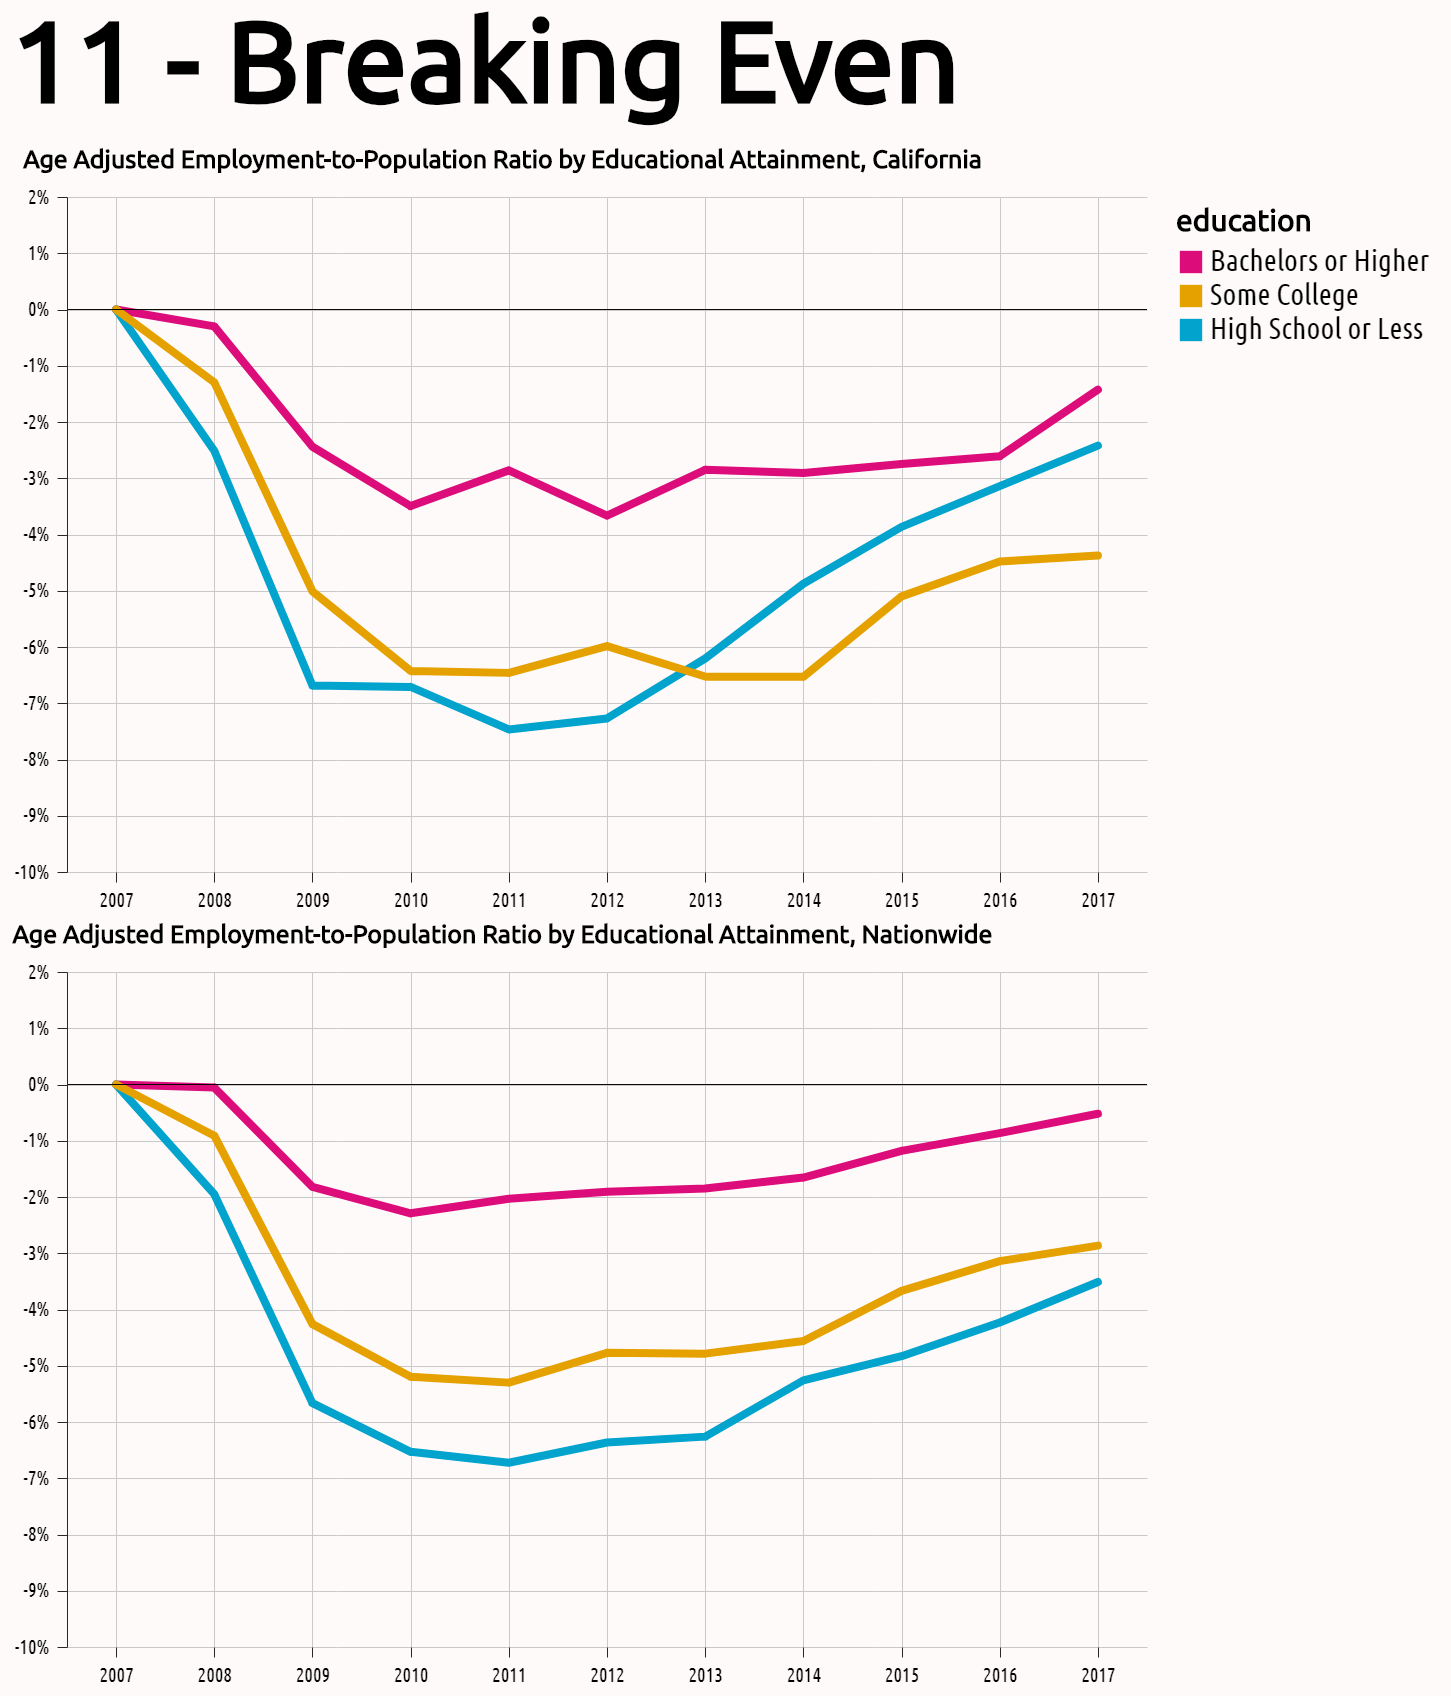

In [17]:
final = final_CA & final_USA
final = final.properties(title = '11 - Breaking Even').configure_title(fontSize = 114).configure_axisLeft(titleAngle= 0, titleY = -25, titleX = 435, titleFontSize=25)
final